# Monte Carlo

This is the simple Monte Carlo example you worked on in class.

Consider the following objective and constraint

\begin{align*}
f(x) &= x_1^2 + 2x_2^2 + 3x_3^2\\
c(x) &= x_1 + x_2 + x_3 \le 3.5
\end{align*}

At the point:

$$x = [1, 1, 1]$$

the standard deviation in $x$ is (normally distributed)

$$\sigma_x = [0.0, 0.06, 0.2]$$

Compute the following:
- Output statistics for $f$ (mean, standard deviation, histogram)
- Reliability of $c$

In [5]:
def func(x):
    return x[0]**2 + 2*x[1]**2 + 3*x[2]**2

def con(x):
    return x[0] + x[1] + x[2] - 3.5  # rewritten in form c <= 0

In [6]:
x = [1.0, 1.0, 1.0]
sigma = [0.00, 0.06, 0.2]

We will use randn, which gives us a random number k sampled from a normal distribution.  It is sampled from a unit normal with zero mean and a standard deviation of 1 so to translate to an arbitrary mean and standard deviation the random value will be
$$ x = \mu + k \sigma $$
If we sample enough times, we should get reliable statistics

In [7]:
import numpy as np

def stats(n):
    f = np.zeros(n)
    c = np.zeros(n)

    for i in range(n):
        x1 = x[0]
        x2 = x[1] + np.random.randn(1)*sigma[1]
        x3 = x[2] + np.random.randn(1)*sigma[2]

        f[i] = func([x1, x2, x3])
        c[i] = con([x1, x2, x3])
        
    # mean
    mu = np.average(f)
    
    # standard deviation
    std = np.std(f, ddof=1)  #ddof=1 gives an unbiased estimate (np.sqrt(1.0/(n-1)*(np.sum(f**2) - n*mu**2)))

    return mu, std, f, c


Let's evaluate this function for different values of n (number of samples) to see how long it takes to converge.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


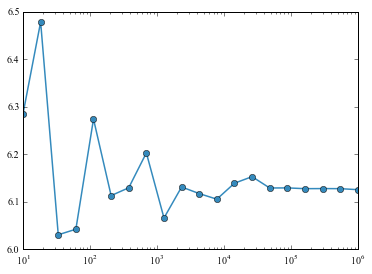

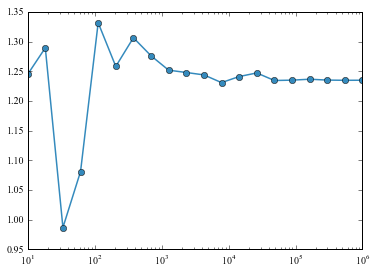

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

nvec = np.logspace(1, 6, 20)
muvec = np.zeros(20)
stdvec = np.zeros(20)

for i, n in enumerate(nvec):
    muvec[i], stdvec[i], _, _ = stats(int(n))
    print i
    
plt.figure()
plt.semilogx(nvec, muvec, '-o')

plt.figure()
plt.semilogx(nvec, stdvec, '-o')
plt.show()

Note that it takes about 100,000 simulations for the statistics to converge.  Let's rerun that case and check our the histogram and statistics.

mu = 6.13291096795
sigma = 1.24154429602


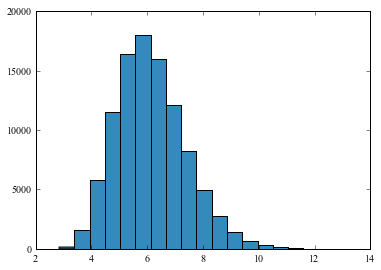

In [20]:
n = 1e5
mu, std, f, c = stats(int(n))
print 'mu =', mu
print 'sigma =', std
plt.figure()
plt.hist(f, bins=20);

Notice that it skews to the right.  Because of the square terms in the function, any deviation causes the function to increase.

We can also estimate our reliability just by counting up our failures (or counting up the number of times the constraint was satisfied).

In [21]:
reliability = np.count_nonzero(c <= 0.0)/float(n)
print 'reliability = ', reliability*100, '%'

reliability =  99.168 %


# Monte Carlo with LHS

In our discussion on surrogate-based optimization we learned about Latin Hypercube Sampling (LHS).  Let's apply LHS to Monte Carlo to see if it speeds up convergence.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


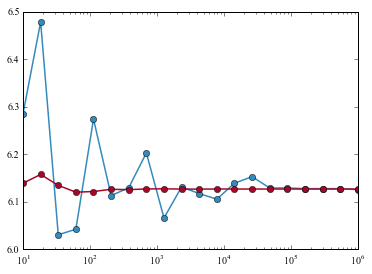

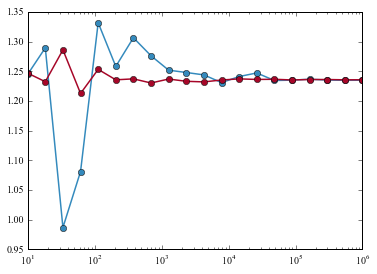

In [22]:
from pyDOE import lhs
from scipy.stats.distributions import norm

def statsLHS(n):
    f = np.zeros(n)
    c = np.zeros(n)
    
    # generate latin hypercube sample points beforehand from normal dist
    lhd = lhs(2, samples=n)
    rpt = norm(loc=0, scale=1).ppf(lhd)

    for i in range(n):
        x1 = x[0]
        x2 = x[1] + rpt[i, 0]*sigma[1]
        x3 = x[2] + rpt[i, 1]*sigma[2]

        f[i] = func([x1, x2, x3])
        c[i] = con([x1, x2, x3])
        
    # mean
    mu = np.average(f)
    
    # standard deviation
    std = np.std(f, ddof=1)  #ddof=1 gives an unbiased estimate (np.sqrt(1.0/(n-1)*(np.sum(f**2) - n*mu**2)))

    return mu, std, f, c


muLHS = np.zeros(20)
stdLHS = np.zeros(20)

for i, n in enumerate(nvec):
    muLHS[i], stdLHS[i], _, _ = statsLHS(int(n))
    print i
    
plt.figure()
plt.semilogx(nvec, muvec, '-o')
plt.semilogx(nvec, muLHS, '-o')

plt.figure()
plt.semilogx(nvec, stdvec, '-o')
plt.semilogx(nvec, stdLHS, '-o')
plt.show()

Notice how much faster Monte Carlo conveges with Latin hypercube sampling as opposed to pure random sampling (particularly in this low dimensional space).